# <center> Logistic Regression </center>

* Features: $x = (x_1, ..., x_n)$
* Target: $y = \{0, 1\}$
* Training example: $(x^{(i)}, y^{(i)})$
* Training set: $\left\{(x^{(i)}, y^{(i)}); i = 1, ..., N\right\}$
* Weights: $w = (w_0, w_1, ..., w_n)$
* For convenience: $x_0 = 1$
* Logistic function: $g(z) = \frac{1}{1 + e^{-z}}$
* Hypothesis: $h (x) = g(w^Tx) = \frac{1}{1 + e^{-w^Tx}}$
* Probability of 1: $P (y = 1 | x, w) = h(x)$
* Probability of 0: $P (y = 0 | x, w) = 1 - h(x)$
* Probability: $p (y | x, w) = (h(x))^y\cdot(1 - h(x))^{1 - y}$
* Likelihood: $L(w) = p(y | X,w) = \prod\limits_{i = 1}^N p(y^{(i)} | x^{(i)}, w) = \prod\limits_{i=1}^N (h(x^{(i)}))^{y^{(i)}}\cdot(1 - h(x^{(i)}))^{1 - y^{(i)}}$
* Log-likelihood: $l(w) = \log L(w) = \sum\limits_{i=1}^Ny^{(i)}\log h(x^{(i)}) + (1 - y^{(i)})\log (1-h(x^{(i)}))$
* Gradient of logistic function: $\frac{dg(z)}{dz} = g(z)(1 - g(z))$
* Gradient of log-likehood: $\frac{\partial l(w)}{\partial w_j} = (y - h(x))\cdot x_j$
* Learning rate: $\alpha$
* Learning step (maximize $l(w)$): $w_j = w_j + \alpha\frac{\partial l(w)}{\partial w_j} = w_j + \alpha\sum\limits_{i=1}^N\left(y^{(i)} - h (x^{(i)})\right)x_j$
* Cost function: $f(w) = -l(w)$
* Learning step (minimize $f(w)$): $w_j = w_j - \alpha\frac{\partial f(w)}{\partial w_j}$
* Note, it is perceptron, when: $g(z) = 1 \text{ for } z \geq 1 \text{ or } 0 \text{ for } z < 1$

# <center> Example </center>

## Generate training sample

In [153]:
%matplotlib inline

### IMPORTS ###

import numpy
import matplotlib.pyplot as plt

rng = numpy.random # random number generator

### SETTINGS ###

N = 1000 # number of samples
n = 4    # number of features

### FUNCTIONS ###

def isInCircle (point): # returns 1 (0) if point is (not) in circle (radius chosen so #inside ~ #outside)
  return int (point[0] * point[0] + point[1] * point[1] < 2 / 3.14)

### GENERATE SAMPLES ###

randomPoints = (2.0 * rng.sample ((N, 2)) - 1) # random points [-1,1]x[-1,1]

X = [[p[0], p[1], p[0]*p[0],p[1]*p[1]] for p in randomPoints] # 4 features: x, y, x^2, y^2
Y = [isInCircle(x) for x in randomPoints]                     # 1/0 for points inside/outside circle

## Plot training sample

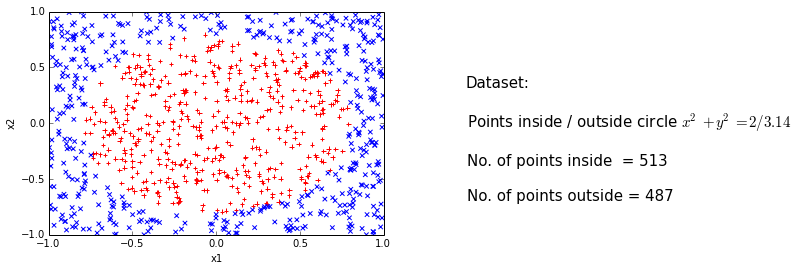

In [154]:
### PLOT SAMPLES ###

# separate points inside and outside circle

inside, outside = [], []

for i in range(N):
    if Y[i]: inside.append(randomPoints[i])
    else: outside.append(randomPoints[i])

# axis settings        
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# plot samples

plt.scatter(*zip(*inside), marker = '+', color = 'r')
plt.scatter(*zip(*outside), marker = 'x', color = 'b')

plt.text(1.5, -1, 'Dataset:\n\n'
                  'Points inside / outside circle $x^2 + y^2 = 2 / 3.14$\n\n'
                  'No. of points inside  = %d\n\n'
                  'No. of points outside = %d\n\n'
                  % (len(inside), len(outside)), fontsize = 15)


plt.show()

## Proceed Theano

In [155]:
### THEANO ###

import theano
import theano.tensor as T

nTrainSteps = 1000 # number of training steps

alpha = 0.01 # learning rate

### SYMBOLIC VARIABLES ###

x = T.matrix('x') # feature vector
y = T.vector('y') # target vector

w = theano.shared(rng.randn(n), name = 'w') # n weights initialized randomly
b = theano.shared(rng.randn(), name = 'b')  # bias term (w_0)

### EXPRESSION GRAPH ###

h = 1 / (1 + T.exp(-T.dot(x, w) - b))          # hypothesis
prediction = h > 0.5                           # prediction threshold
xent = - y * T.log(h) - (1 - y) * T.log(1 - h) # cross-entropy loss function
cost = xent.sum()                              # cost function
gw, gb = T.grad(cost, [w,b])                   # gradients

### COMPILE ###

# update weights based on gradients, calculalted using x,y and return cost function value
train = theano.function(inputs = [x,y],
                        outputs = cost,
                        updates = ((w, w - alpha * gw), (b, b - alpha * gb)))

### TRAIN ###

costs = [] # value of cost function in each training step

for i in range(nTrainSteps): costs.append(train(X, Y))

## Plot results

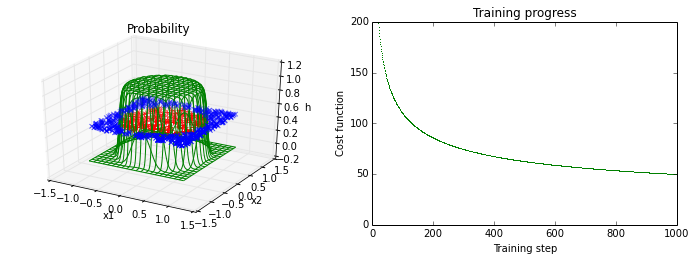

In [156]:
### PLOT RESULTS ###

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
fig.set_size_inches((2, 2) * fig.get_size_inches())

# hypothesis / probability

x1 = numpy.arange(-1, 1, 0.01)
x2 = numpy.arange(-1, 1, 0.01)
x1, x2 = numpy.meshgrid(x1, x2)

a = w.get_value() # calculated weights

h = 1 / (1 + numpy.exp(-a[0] * x1 - a[1] * x2 - a[2] * x1 * x1 - a[3] * x2 * x2 - b.get_value())) # h(x)

ax = fig.add_subplot(221, projection='3d')

ax.set_title('Probability')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('h')

inside  = [[i[0], i[1], 0.5] for i in inside]  # add z-dimension to training points
outside = [[o[0], o[1], 0.5] for o in outside] # z = probability threshold

ax.plot_wireframe(x1, x2, h, rstride = 10, cstride = 10, color = 'g') # plot h(x)

ax.scatter(*zip(*outside), marker = 'x', color = 'b') # plot training points outside circle
ax.scatter(*zip(*inside),  marker = '+', color = 'r') # plot training points inside circle

# training progress

ax = fig.add_subplot(222)

ax.set_title('Training progress')
ax.set_xlabel('Training step')
ax.set_ylabel('Cost function')

steps = []
steps.extend(range(0,nTrainSteps))

plt.ylim([0, 200])
ax.plot(steps, costs, 'g,')

plt.show()

## Test

In [157]:
### COMPILE THEANO FUNTION ###

predict = theano.function(inputs = [x], outputs = prediction)

### SETTINGS ###

score = 0
nTest = 1000 # number of testing samples

### TESTING SAMPLES ###

randomPoints = (2.0 * rng.sample ((nTest, 2)) - 1) # random points [-1,1]x[-1,1]

testSample = [[p[0], p[1], p[0] * p[0], p[1] * p[1]] for p in randomPoints] # (x1, x2, x1^2, x2^2)

### PREDICT AND CALCULATE SCORE ###

result = predict (testSample) # predict inside / outside for testing sample

for i in range(nTest):
    if result[i] == isInCircle(randomPoints[i]): score += 1
        
print "Score = ", 1.0 * score / nTest

Score =  0.991
